<p style="font-size:24pt; font-weight: bold; line-height: 120%;">Quantum State Transfer and Entanglement Distribution among Distant Nodes in a Quantum Network</p>

This reproduces Cirac et al, PRL 78, 3221 (1997)

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import copy
from os.path import join
from collections import OrderedDict

In [3]:
import sympy
import numpy as np

In [4]:
import two_node_checks

In [5]:
sympy.init_printing()

In [6]:
%matplotlib inline

In [7]:
import matplotlib.pylab as plt

# SLH Description

In [8]:
from two_node_slh import qnet_node_system, setup_qnet_sys

In [9]:
n_cavity = 2

In [10]:
SYS, Sym1, Op1, Sym2, Op2 = setup_qnet_sys(n_cavity=n_cavity)

In [11]:
SYS.H

OperatorPlus(ScalarTimesOperator(-g_{1}**2/\Delta_{1}, OperatorTimes(Create(LocalSpace('cav', '1')), Destroy(LocalSpace('cav', '1')))), ScalarTimesOperator(I*\kappa, OperatorTimes(Create(LocalSpace('cav', '1')), Destroy(LocalSpace('cav', '2')))), ScalarTimesOperator(-g_{2}**2/\Delta_{2}, OperatorTimes(Create(LocalSpace('cav', '2')), Destroy(LocalSpace('cav', '2')))), ScalarTimesOperator(-I*\kappa, OperatorTimes(Destroy(LocalSpace('cav', '1')), Create(LocalSpace('cav', '2')))), ScalarTimesOperator(-I*\Omega_{1}*g_{1}/(2*\Delta_{1}), OperatorTimes(LocalSigma(LocalSpace('atom', '1'), 'e', 'g'), Destroy(LocalSpace('cav', '1')))), ScalarTimesOperator(I*\Omega_{1}*g_{1}/(2*\Delta_{1}), OperatorTimes(LocalSigma(LocalSpace('atom', '1'), 'g', 'e'), Create(LocalSpace('cav', '1')))), ScalarTimesOperator(g_{1}**2/\Delta_{1}, OperatorTimes(LocalSigma(LocalSpace('atom', '1'), 'g', 'g'), Create(LocalSpace('cav', '1')), Destroy(LocalSpace('cav', '1')))), ScalarTimesOperator(-I*\Omega_{2}*g_{2}/(2*\Del

In [12]:
SYS.L

Matrix([[OperatorPlus(ScalarTimesOperator(sqrt(2)*sqrt(\kappa), Destroy(LocalSpace('cav', '1'))), ScalarTimesOperator(sqrt(2)*sqrt(\kappa), Destroy(LocalSpace('cav', '2'))))]])

In [13]:
SYS.H.space

ProductSpace(LocalSpace('atom', '1'), LocalSpace('atom', '2'), LocalSpace('cav', '1'), LocalSpace('cav', '2'))

# Numerical Setup

In [14]:
import QDYN
from QDYN.units import UnitFloat
from two_node_qdyn import make_qdyn_model, state, err_state_to_state, prepare_rf_prop
from shwrapper import qdyn_optimize, qdyn_prop_traj, env
from notebook_plots import show_observables

In [15]:
Delta = 5000  # MHz
g     =   50  # MHz
kappa =  0.5  # MHz

In [16]:
psi01 = state(SYS, 0, 1, 0, 0)
psi10 = state(SYS, 1, 0, 0, 0)

# Analytical Solution

Analytical pulses are generated in [AnalyticalSolution](AnalyticalSolution.ipynb). The time grid is determined there. The parameters must match those defined above.

In [17]:
omega1 = QDYN.pulse.Pulse.read("omega1_analytical.dat")
omega2 = QDYN.pulse.Pulse.read("omega2_analytical.dat")

In [18]:
# Check that parameters are consistent with those for which the pulses were 
# generated
for omega in (omega1, omega2):
    assert omega.ampl_unit == 'MHz'
    assert (abs(np.abs(np.max(omega.amplitude))
                - (float(2 * Delta * kappa)/float(g))) < 1e-14)

In [19]:
analytical_model = make_qdyn_model(
    SYS, Delta, g, kappa, Sym1, Op1, Sym2, Op2,
    pulse1=omega1, pulse2=omega2, mcwf=True, non_herm=False,
    states={'': psi10}, set_observables=True)

In [20]:
rf = './rf_analytical_model'

In [21]:
analytical_model.write_to_runfolder(rf)

In [22]:
__ = qdyn_prop_traj(['--n-trajs=2', rf], _out=join(rf, 'prop.log'))

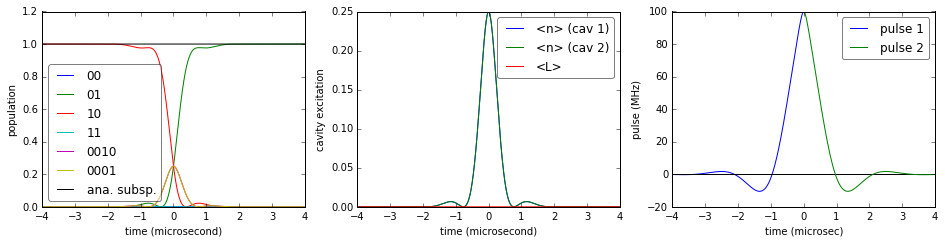

In [23]:
show_observables(rf)

In [24]:
"%.2e" % err_state_to_state(state(SYS, 0, 1, 0, 0, fmt='numpy'), join(rf, 'psi_final.dat.*'))

'1.01e-06'

# OCT for bidirectional state-to-state

In [25]:
def oct_bidir_model(mcwf=True, non_herm=False, set_observables=True,            
        lambda_a=1e-5):
    guess_omega1 = QDYN.pulse.Pulse.read("omega1_symmetrized.dat")
    guess_omega2 = QDYN.pulse.Pulse.read("omega2_symmetrized.dat")
    states=OrderedDict([('10', psi10), ('01', psi01)])
    model = make_qdyn_model(
        SYS, Delta, g, kappa, Sym1, Op1, Sym2, Op2,
        pulse1=guess_omega1, pulse2=guess_omega2,
        mcwf=mcwf, non_herm=non_herm, states=states,
        set_observables=set_observables)
    pulse_settings = {
        guess_omega1: {
            'oct_shape': 'flattop',
            'shape_t_start': guess_omega1.t0, 'shape_t_stop': guess_omega1.T,
            't_rise': 0.1*guess_omega1.T, 't_fall': 0.1*guess_omega1.T,
            'oct_lambda_a' : lambda_a, 'oct_increase_factor': 5,
            'oct_outfile' : 'pulse1.oct.dat'
        }
    }
    pulse_settings[guess_omega2] = copy.copy(pulse_settings[guess_omega1])
    pulse_settings[guess_omega2]['oct_outfile'] = 'pulse2.oct.dat'
    model.set_oct(pulse_settings, method='krotovpk', J_T_conv=1e-4,
                  max_ram_mb=500, iter_dat='oct_iters.dat', iter_stop=50,
                  tau_dat='oct_tau.dat', params_file='oct_params.dat')
    model.user_data['initial_states'] = '01,10'
    model.user_data['target_states'] = '10,01'
    model.user_data['seed'] = 0
    return model

## Guess pulse (bidir)

In [26]:
rf_guess10 = './rf_bidirect_oct_guess10'
rf_guess01 = './rf_bidirect_oct_guess01'

In [27]:
oct_bidir_model().write_to_runfolder(rf_guess10)
oct_bidir_model().write_to_runfolder(rf_guess01)

In [28]:
__ = qdyn_prop_traj(['--n-trajs=20', '--state-label=10', rf_guess10], _out=join(rf_guess10, 'prop.log'))
__ = qdyn_prop_traj(['--n-trajs=20', '--state-label=01', rf_guess01], _out=join(rf_guess01, 'prop.log'))

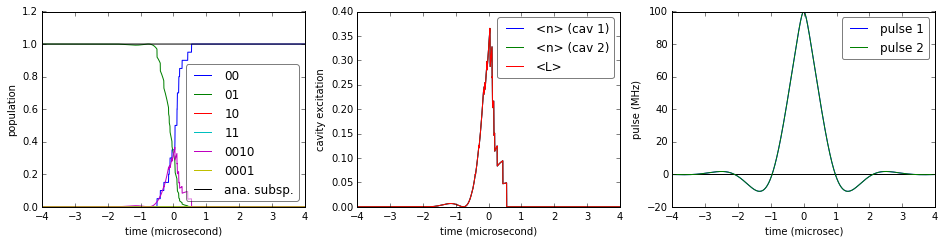

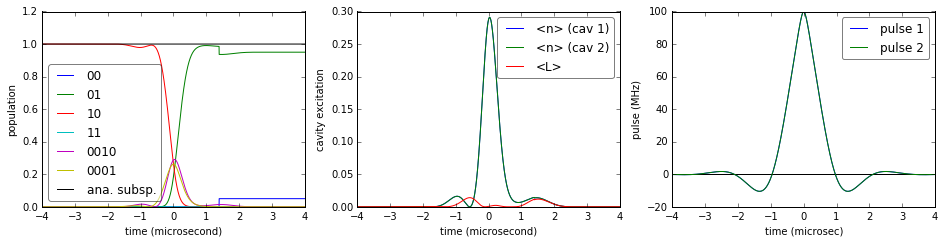

In [29]:
show_observables(rf_guess01)
show_observables(rf_guess10)

In [30]:
"%.2e" % err_state_to_state(state(SYS, 1, 0, 0, 0, fmt='numpy'), join(rf_guess01, 'psi_final.dat.*'))

'1.00e+00'

In [31]:
"%.2e" % err_state_to_state(state(SYS, 0, 1, 0, 0, fmt='numpy'), join(rf_guess10, 'psi_final.dat.*'))

'5.00e-02'

## Optimization (bidir)

### Liouville optimization (bidir)

In [32]:
rf_oct = './rf_bidirect_oct_liouville'

In [33]:
oct_bidir_model(set_observables=False, mcwf=False).write_to_runfolder(rf_oct)

In [34]:
two_node_checks.check_oct_bidir_liouville(rf_oct, SYS, n_cavity)
pc = qdyn_optimize(['--rho', '--debug', '--J_T=J_T_re', rf_oct],
                   _out=join(rf_oct, 'oct.log'))

In [35]:
rf_prop01 = './rf_bidirect_oct_liouville_prop01'
rf_prop10 = './rf_bidirect_oct_liouville_prop10'
prepare_rf_prop(oct_bidir_model(), rf_oct, rf_prop01, rf_prop10,
                oct_pulses='pulse*.oct.dat')

In [36]:
__ = qdyn_prop_traj(['--n-trajs=20', '--state-label=10', '--use-oct-pulses', 
                     rf_prop10], _out=join(rf_prop10, 'prop.log'))
__ = qdyn_prop_traj(['--n-trajs=20', '--state-label=01', '--use-oct-pulses',
                     rf_prop01], _out=join(rf_prop01, 'prop.log'))

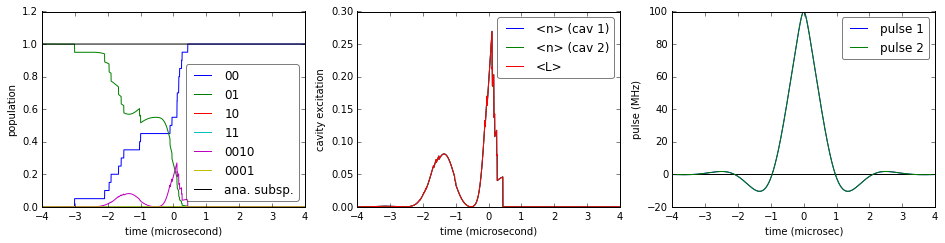

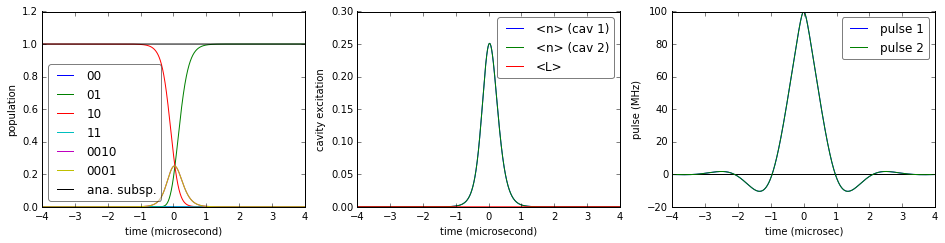

In [37]:
show_observables(rf_prop01)
show_observables(rf_prop10)

In [38]:
"%.2e" % err_state_to_state(state(SYS, 1, 0, 0, 0, fmt='numpy'), join(rf_guess01, 'psi_final.dat.*'))

'1.00e+00'

In [39]:
"%.2e" % err_state_to_state(state(SYS, 0, 1, 0, 0, fmt='numpy'), join(rf_guess10, 'psi_final.dat.*'))

'5.00e-02'

### MCWF optimization (bidir)

In [40]:
rf_oct = './rf_bidirect_oct_mcwf'

In [41]:
oct_bidir_model(set_observables=False).write_to_runfolder(rf_oct)

In [42]:
two_node_checks.check_oct_bidir_mcwf(rf_oct, SYS, n_cavity)
pc = qdyn_optimize(['--n-trajs=20', '--J_T=J_T_sm', rf_oct],
                   _out=join(rf_oct, 'oct.log'),
                   _env=env(OMP_NUM_THREADS=20))

In [43]:
rf_prop01 = './rf_bidirect_oct_mcwf_prop01'
rf_prop10 = './rf_bidirect_oct_mcwf_prop10'
prepare_rf_prop(oct_bidir_model(), rf_oct, rf_prop01, rf_prop10,
                oct_pulses='pulse*.oct.dat')

In [44]:
__ = qdyn_prop_traj(['--n-trajs=20', '--state-label=10', '--use-oct-pulses',
                     rf_prop10], _out=join(rf_prop10, 'prop.log'))
__ = qdyn_prop_traj(['--n-trajs=20', '--state-label=01', '--use-oct-pulses',
                     rf_prop01], _out=join(rf_prop01, 'prop.log'))

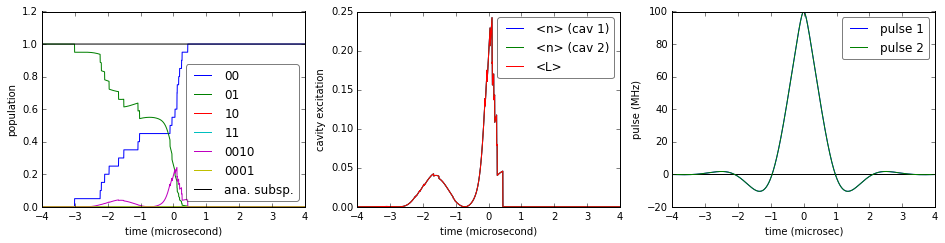

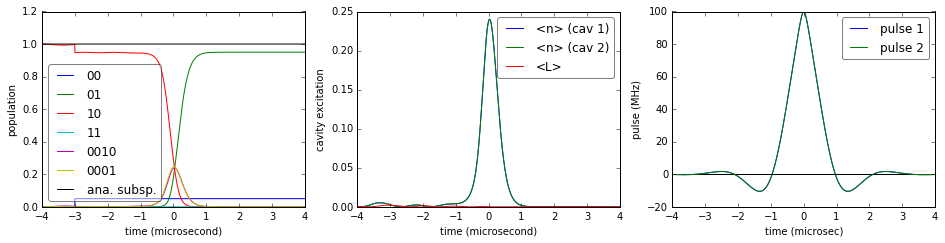

In [45]:
show_observables(rf_prop01)
show_observables(rf_prop10)

In [46]:
"%.2e" % err_state_to_state(state(SYS, 1, 0, 0, 0, fmt='numpy'), join(rf_guess01, 'psi_final.dat.*'))

'1.00e+00'

In [47]:
"%.2e" % err_state_to_state(state(SYS, 0, 1, 0, 0, fmt='numpy'), join(rf_guess10, 'psi_final.dat.*'))

'5.00e-02'

# OCT for uni-directional state-to-state

In [48]:
def oct_unidir_model(mcwf=True, non_herm=False, set_observables=True,            
        lambda_a=1e-5, variation=None):
    from QDYN.pulse import blackman
    guess_omega1 = QDYN.pulse.Pulse.read("omega1_analytical.dat")
    guess_omega2 = QDYN.pulse.Pulse.read("omega2_analytical.dat")
    B = blackman(guess_omega1.tgrid, float(guess_omega1.t0),
                 float(guess_omega1.T))
    guess_omega1.amplitude = 70 * B
    guess_omega2.amplitude = 70* B
    if variation == 'short':
        guess_omega1 = QDYN.pulse.Pulse.read("omega1_short.dat") # compressed!
        guess_omega2 = QDYN.pulse.Pulse.read("omega2_short.dat")
        shape = QDYN.pulse.flattop(guess_omega1.tgrid, t_start=float(guess_omega1.t0),
                                   t_stop=float(guess_omega1.T),
                                   t_rise=float(0.1*guess_omega1.T))
        guess_omega1.amplitude *= 4*shape  # matches compression factor 4 in pulse
        guess_omega2.amplitude *= 4*shape
    states=OrderedDict([('10', psi10), ('01', psi01)])
    model = make_qdyn_model(
        SYS, Delta, g, kappa, Sym1, Op1, Sym2, Op2,
        pulse1=guess_omega1, pulse2=guess_omega2,
        mcwf=mcwf, non_herm=non_herm, states=states,
        set_observables=set_observables)
    pulse_settings = {
        guess_omega1: {
            'oct_shape': 'flattop',
            'shape_t_start': guess_omega1.t0, 'shape_t_stop': guess_omega1.T,
            't_rise': 0.1*guess_omega1.T, 't_fall': 0.1*guess_omega1.T,
            'oct_lambda_a' : lambda_a, 'oct_increase_factor': 5,
            'oct_outfile' : 'pulse1.oct.dat',
            'oct_pulse_max': UnitFloat(420, 'MHz'),
            'oct_pulse_min':  UnitFloat(-100, 'MHz')
        }
    }
    pulse_settings[guess_omega2] = copy.copy(pulse_settings[guess_omega1])
    pulse_settings[guess_omega2]['oct_outfile'] = 'pulse2.oct.dat'
    model.set_oct(pulse_settings, method='krotovpk', J_T_conv=1e-4,
                  max_ram_mb=500, iter_dat='oct_iters.dat', iter_stop=50,
                  tau_dat='oct_tau.dat', params_file='oct_params.dat',
                  limit_pulses=True)
    model.user_data['initial_states'] = '10'
    model.user_data['target_states'] = '01'
    model.user_data['seed'] = 0
    return model

## Guess pulse (unidir)

In [49]:
rf_guess = './rf_unidirect_oct_guess'

In [50]:
oct_unidir_model().write_to_runfolder(rf_guess)

In [51]:
__ = qdyn_prop_traj(['--n-trajs=20', '--state-label=10', rf_guess],
                    _out=join(rf_guess, 'prop.log'))

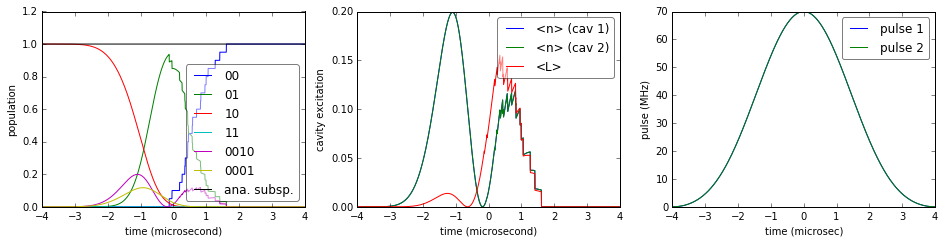

In [52]:
show_observables(rf_guess)

In [53]:
"%.2e" % err_state_to_state(state(SYS, 0, 1, 0, 0, fmt='numpy'), join(rf_guess, 'psi_final.dat.*'))

'1.00e+00'

## Optimization (unidir)

### Liouville optimization (unidir)

In [54]:
rf_oct = './rf_unidirect_oct_liouville'

In [55]:
oct_unidir_model(set_observables=False, mcwf=False, lambda_a=1e-2).write_to_runfolder(rf_oct)

In [56]:
two_node_checks.check_oct_unidir_liouville(rf_oct, SYS, n_cavity)
pc = qdyn_optimize(['--rho', '--debug', '--J_T=J_T_re', rf_oct],
                   _out=join(rf_oct, 'oct.log'))

In [57]:
rf_prop = './rf_unidirect_oct_liouville_prop'

In [58]:
prepare_rf_prop(oct_unidir_model(), rf_oct, rf_prop,
                oct_pulses='pulse*.oct.dat')

In [59]:
__ = qdyn_prop_traj(['--n-trajs=20', '--state-label=10', '--use-oct-pulses',
                     rf_prop], _out=join(rf_prop, 'prop.log'))

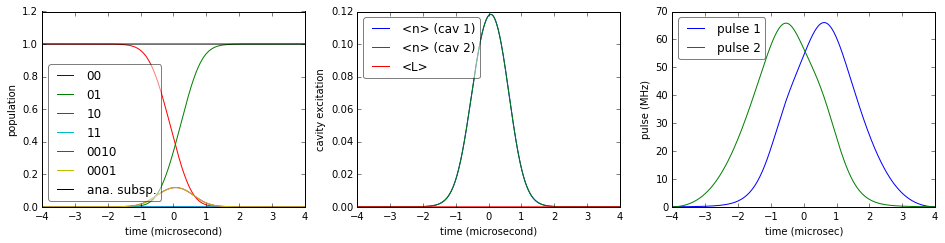

In [60]:
show_observables(rf_prop, pulse1_file='pulse1.oct.dat', pulse2_file='pulse2.oct.dat')

In [61]:
"%.2e" % err_state_to_state(psi01, join(rf_prop, 'psi_final.dat.*'))

'5.22e-05'

### MCWF optimization (unidir)

In [62]:
rf_oct = './rf_unidirect_oct_mcwf'

In [63]:
oct_unidir_model(set_observables=False, mcwf=True, lambda_a=1e-2).write_to_runfolder(rf_oct)

In [64]:
two_node_checks.check_oct_unidir_mcwf(rf_oct, SYS, n_cavity)
pc = qdyn_optimize(['--n-trajs=20', '--J_T=J_T_sm', rf_oct],
                   _out=join(rf_oct, 'oct.log'),
                   _env=env(OMP_NUM_THREADS=20))

In [65]:
rf_prop = './rf_unidirect_oct_mcwf_prop'
prepare_rf_prop(oct_unidir_model(), rf_oct, rf_prop,
                oct_pulses='pulse*.oct.dat')

In [66]:
__ = qdyn_prop_traj(['--n-trajs=20', '--state-label=10', '--use-oct-pulses',
                     rf_prop], _out=join(rf_prop, 'prop.log'))

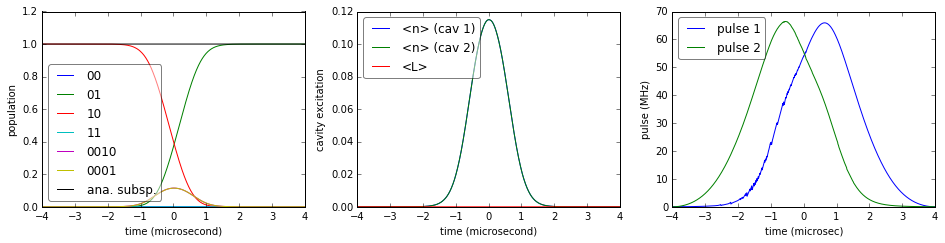

In [67]:
show_observables(rf_prop, pulse1_file='pulse1.oct.dat', pulse2_file='pulse2.oct.dat')

In [68]:
"%.2e" % err_state_to_state(psi10, join(rf_guess01, 'psi_final.dat.*'))

'1.00e+00'

# Scratch

In [69]:
import copy